In [1]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import stanza

from plotly.subplots import make_subplots
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer

tqdm.pandas()

import plotly.io as pio
pio.renderers.default = 'png'

In [2]:
# We allow the program to read in saved tables in order to reduce running time, which can be quite large.
recalculate_all = False

In [3]:
base_path = '.'
spreadsheets_path = 'Movie_spreadsheets'
data_path = os.path.join(base_path, spreadsheets_path)
intermediate_path = os.path.join(base_path, 'intermediate')

# Data Processing

In [4]:
def split_lines_with_character_tags(df):
    # Remove text which are labeled character names but which are not all caps (which often indicate stage directions)
    df['line #'] = df.index
    df['line'] = df['line'].str.replace('\n', ' ', regex=True)
    df = df[df['character'].str.isupper()]
    
    # Remove parentheticals such as "(CONTD)" or "(V.O.)"
    df['character'] = df['character'].str.replace(r"\(.+\)", '', regex=True).str.strip()
    df['original character'] = df['character']
    df['line'] = df['line'].str.replace(r'\(cont.+d\)', '', flags=re.IGNORECASE, regex=True)
    df = df[df['character'].str.strip().str.len() != 0]


    for character in df['original character'].unique():
        # If the name of a character (ONLY if in all caps, as is expected of character headers)
        # appears in a section of speech, separate it into another section of speech.
        # This is because we frequently observed one character's speech being contaminated with another's, e.g.:
            # SAM: Hi there how's it going? ALICE: I'm doing well
            # SAM: Glad to hear it.
        while len(df[df['line'].str.contains(re.escape(character), regex=True)]) > 0:
            new_rows = df[df['line'].str.contains(character, regex=True)].copy()
            new_rows.loc[:,'line'] = new_rows['line'].str.split(character).apply(lambda x: x[1])
            df.loc[:,'line'] = df['line'].str.split(character).apply(lambda x: x[0])
            new_rows['character'] = character
            new_rows.loc[:,'line #'] += .001
            df = df.append(new_rows)
            df = df.sort_values(by='line #').reset_index(drop=True)
            df.loc[:, 'line #'] = df.index

    df = df.drop('original character', axis=1)        
    df['character'] = df['character'].str.replace(r'[^A-z]','', regex=True)

    df ['line'] = df['line'].str.replace('\r', '', regex=True)
    df['line'] = df['line'].str.replace('\\\'', '\'', regex=True)
    df = df[df['line'].str.strip().str.len() != 0]
    df = df[df['character'].str.strip().str.len() != 0]
    df = df.dropna()
    return df

In [5]:
# Silence chained assignment warnings which are incorrect
pd.options.mode.chained_assignment = None

In [6]:
if recalculate_all:
    # For every movie in the dataset, run the cleaning function
    df = pd.DataFrame()
    movie_id = 0
    for file in tqdm(sorted(os.listdir(data_path))):
        if file.endswith('.csv'):
            movie_title = file.replace('.csv', '')
            # print(movie_title)
            individual_df = pd.read_csv(os.path.join(data_path, file), index_col=0)
            # print(file)
            # print(individual_df.head())
            individual_df['movie_id'] = movie_id
            movie_id += 1
            individual_df['movie_title'] = movie_title
            individual_df = split_lines_with_character_tags(individual_df)
            df = df.append(individual_df)

    # Weird problem in the labeling of Black Panther
    df = df[~df['character'].isin(['T', 'A', 'N'])]
    df = df.reset_index(drop=True)

100%|████████████████████████████████████████████████| 90/90 [00:04<00:00, 19.95it/s]


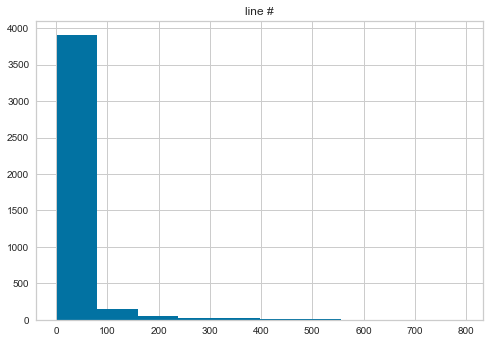

In [7]:
if recalculate_all:
    # Find the number of lines per character
    character_counts = pd.DataFrame(df.groupby(['character', 'movie_title'])['line #'].count())
    character_counts.hist()

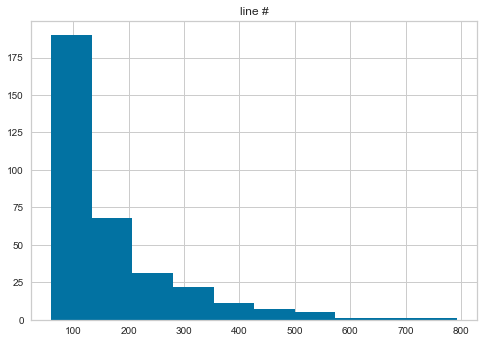

In [8]:
if recalculate_all:
    top_character_counts = character_counts[character_counts['line #'] >= 60]
    bottom_character_counts = character_counts[character_counts['line #'] <= 60]
    top_character_counts.hist()

In [9]:
if recalculate_all:
    # Drop any characters who have less than 60 lines
    for character, movie in tqdm(bottom_character_counts.index):
        df = df[~((df['character'] == character) & (df['movie_title'] == movie))]

100%|███████████████████████████████████████████| 3833/3833 [00:33<00:00, 113.08it/s]


# Sentiment Scoring

We use the stanford Stanza library to assign a sentiment score to every line. The library assigns sentiment scores for each sentence (0, 1, or 2). If a line contains multiple sentences, we take the average (mean) sentiment of the line.

In [10]:
if recalculate_all:
    stanza.download('en')
    nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', use_gpu=False)

    def sentiment_score(text):
        doc = nlp(text)
        scores = []
        for i, sentence in enumerate(doc.sentences):
            scores.append(sentence.sentiment)
        return np.mean(scores)
    
    df['sentiment'] = df['line'].progress_apply(sentiment_score)

2021-11-30 09:17:30 INFO: Downloading default packages for language: en (English)...
2021-11-30 09:17:31 INFO: File exists: /Users/aaron/stanza_resources/en/default.zip.
2021-11-30 09:17:35 INFO: Finished downloading models and saved to /Users/aaron/stanza_resources.
2021-11-30 09:17:35 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-11-30 09:17:35 INFO: Use device: cpu
2021-11-30 09:17:35 INFO: Loading: tokenize
2021-11-30 09:17:35 INFO: Loading: sentiment
2021-11-30 09:17:35 INFO: Done loading processors!
  0%|                                                      | 0/54174 [00:00<?, ?it/s]/Users/aaron/opt/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered inte

In [17]:
# Get a new line ID which gives the position of the line in the whole movie, not simply in the character's lines
# This enables us to know, for example, whether a line occurred in the beginning or end of the movie
# rather than just in the beginning or end of a character's own dialog
if recalculate_all:
    df['movie_length'] = 0
    for movie_id in tqdm(df['movie_id']):
        movie_length = df.loc[df['movie_id'] == movie_id]['line #'].max()
        df.loc[df['movie_id'] == movie_id, 'movie_length'] = movie_length
    df['relative_line_id'] = df['line #'] / df['movie_length']

100%|████████████████████████████████████████| 54174/54174 [00:26<00:00, 2011.73it/s]


In [18]:
# Assign an index which contains both the character and movie name. 
# If we did not elect to recalculate everything, we now load in the existing sentiment scores
if recalculate_all:
    df['combined_name'] = df['movie_title'].str.cat(df['character'], sep='_')
    df.to_csv(os.path.join(intermediate_path, 'movie_df.csv'))
else:
    df = pd.read_csv(os.path.join(intermediate_path, 'movie_df.csv'))

In [19]:
if recalculate_all:
    expanded_movie_size = df['movie_length'].max()
    sentiment_df = np.ones(shape=(len(df['combined_name'].unique()), expanded_movie_size))
    sentiment_df = pd.DataFrame(sentiment_df)
    sentiment_df.index = df['combined_name'].unique()

    # Arbitrarily mark cells whose sentiment scores did not originate from the movie dataframe.
    # True sentiment scores cannot be less than 0
    sentiment_df = sentiment_df * -10
    
    # We standardize the length of movies by assigning each line to the index of its relative position in the movie 
    # (e.g. 66% of the way through) to its position in the expanded standardized movie length
    # e.g. if the longest movie had 5000 lines, a line at 66% of the way through its own movie
    # would be assigned to position 3300 in its new "relative" movie length
    for row in df.iterrows():
        sentiment_df.loc[row[1]['combined_name'], np.round(row[1]['relative_line_id'] * (expanded_movie_size - 1))] = row[1]['sentiment']

In [20]:
np.random.seed(42)

def expand_row(line):
    # To allow comparison, we needed to fill in the empty values where character was not speaking. We elected to 
    # maintain the character's previous sentiment for all non-speaking lines, adding some gaussian noise
    row = line.copy()
    std = row[row != -10].std()
    if row[0] == -10:
        first_nonempty_index = row[row != -10].index[0]
        first_nonempty_value = row[row != -10].loc[first_nonempty_index]
        gaussian_noise = np.random.normal(0, std, size=first_nonempty_index)
        row[:first_nonempty_index] = first_nonempty_value + gaussian_noise
    for i in range(len(row)):
        if row[i] == -10:
            gaussian_noise = np.random.normal(0, std)
            row[i] = last_val + gaussian_noise
        else:
            last_val = row[i]
    # Standardize each character's arc to have a mean of 0 and a standard deviation of 1
    # std = row.std()
    # row = (row - row.mean()) / std

    return row
        
if recalculate_all:
    sentiment_df = sentiment_df.progress_apply(expand_row, axis=1)
    sentiment_df.to_csv(os.path.join(intermediate_path, 'sentiment_df.csv'))
else:
    sentiment_df = pd.read_csv(os.path.join(intermediate_path, 'sentiment_df.csv'), index_col=0)

100%|██████████████████████████████████████████████| 328/328 [00:06<00:00, 54.52it/s]


# PCA

We perform principal component analysis for dimensionality reduction to inspect for visible clusters

In [21]:
pca = PCA(random_state=42)

In [22]:
normalized_sentiment_df = sentiment_df.copy().T
normalized_sentiment_df = (normalized_sentiment_df - normalized_sentiment_df.mean()) / normalized_sentiment_df.std()
normalized_sentiment_df = normalized_sentiment_df.T


In [23]:
# For PCA, we use a very small smoothing window (3 timepoints across) to reduce noise
rolling_df = normalized_sentiment_df.rolling(3, axis=1).mean().dropna(axis=1)

In [24]:
pca_df = pd.DataFrame(pca.fit_transform(rolling_df))
pca_df.index = rolling_df.index

### Plot the standard deviation of all movies across time

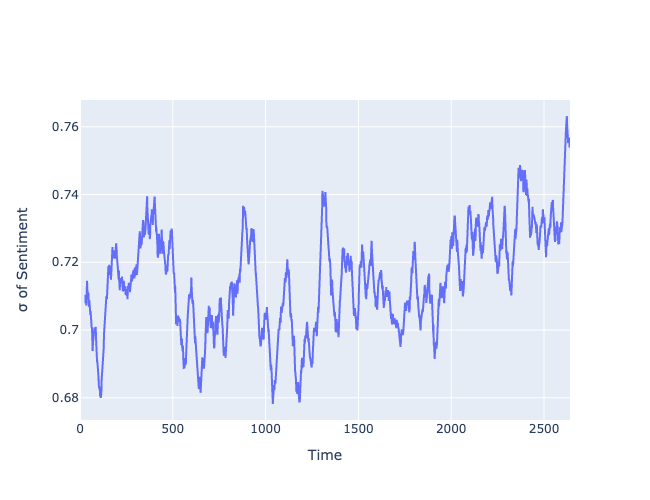

In [25]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=sentiment_df.columns, y=sentiment_df.std().rolling(30).mean(), mode='lines'))
# fig = go.Scatter()
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="σ of Sentiment",
                  )
fig.show()

### Plot the average sentiment over time for all characters

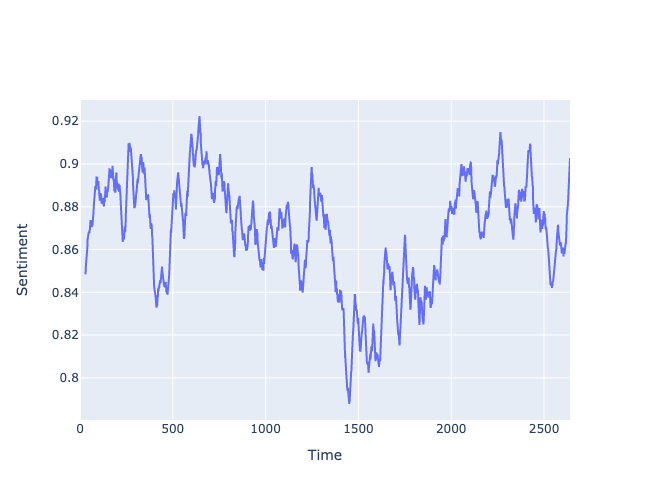

In [26]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=sentiment_df.columns, y=sentiment_df.mean().rolling(30).mean(), mode='lines'))
# fig = go.Scatter()
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

All characters' first two principal components visualized

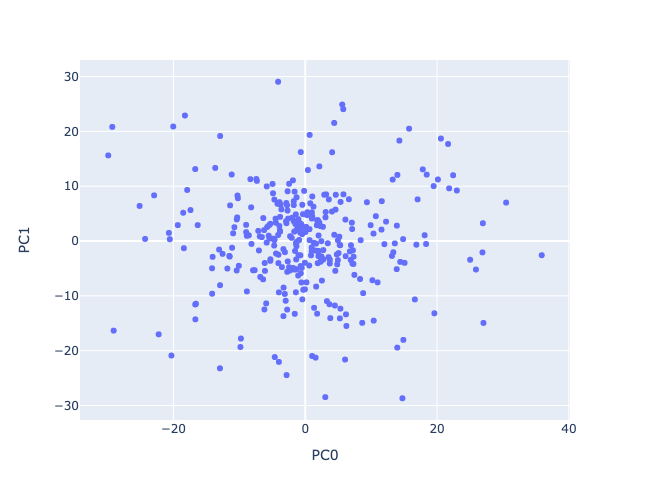

In [27]:
fig = px.scatter(pca_df.reset_index(), 0, 1, hover_name='index', width=650, height=500)
fig.update_layout(
    xaxis_title="PC0",
    yaxis_title="PC1",

)
fig.show()

### Visualizing First Principal Component

In [28]:
midpoint = len(sentiment_df) // 2

def melt_sentiment_df(df):
    return pd.melt(df.reset_index(), id_vars='index').rename({'index': 'Character', 'variable': 'Time', 'value': 'Sentiment'}, axis=1)

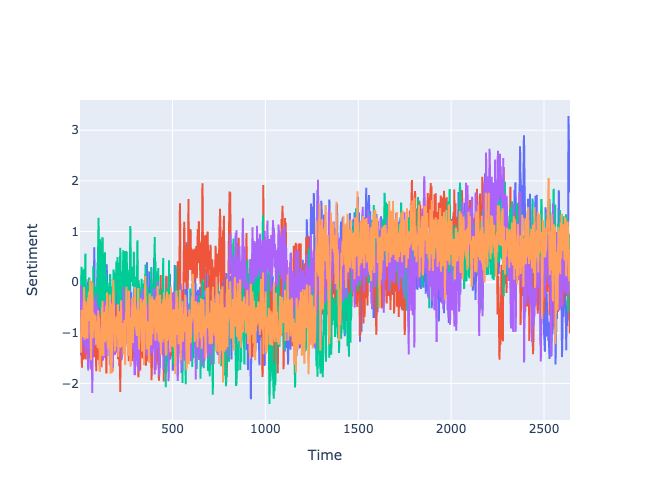

In [29]:

temp_df = rolling_df.loc[pca_df.sort_values(0).iloc[-5:].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

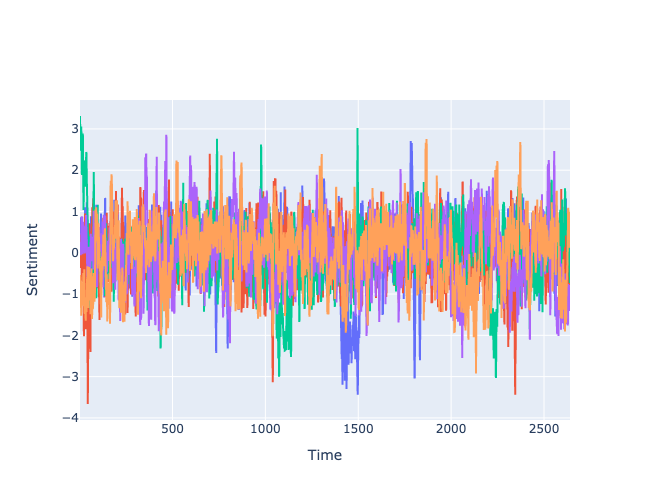

In [30]:
temp_df = rolling_df.loc[pca_df.sort_values(0).iloc[midpoint-2:midpoint+3].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

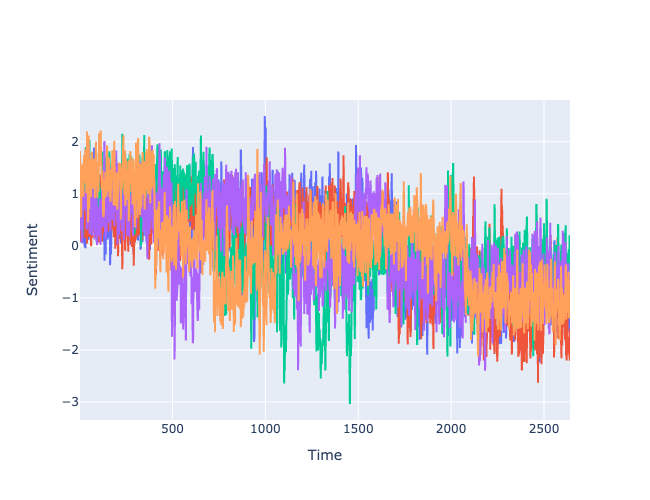

In [31]:
temp_df = rolling_df.loc[pca_df.sort_values(0).iloc[:5].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

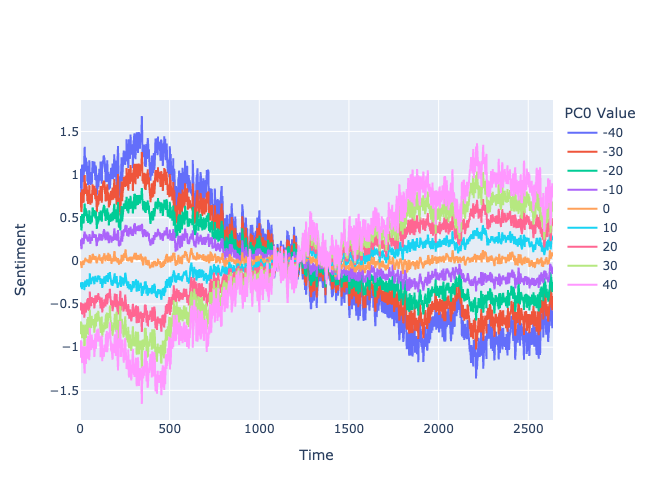

In [32]:
fig = go.Figure()

first_component_example = pd.DataFrame(columns=list(range(pca.n_components_)))

for i in range(-40, 41, 10):
    instance = pd.Series([0 for i in range(pca.n_components_)])
    instance[0] = i
    first_component_example.loc[i] = instance
    
first_component_df = pd.DataFrame(pca.inverse_transform(first_component_example), index=first_component_example.index)
    
for index in first_component_df.index:
    fig.add_trace(go.Scatter(x=first_component_df.columns, y=first_component_df.loc[index],
                    mode='lines', name=str(index)))
fig.update_layout(
                    legend_title_text='PC0 Value',
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

### Visualizing Second Principal Component

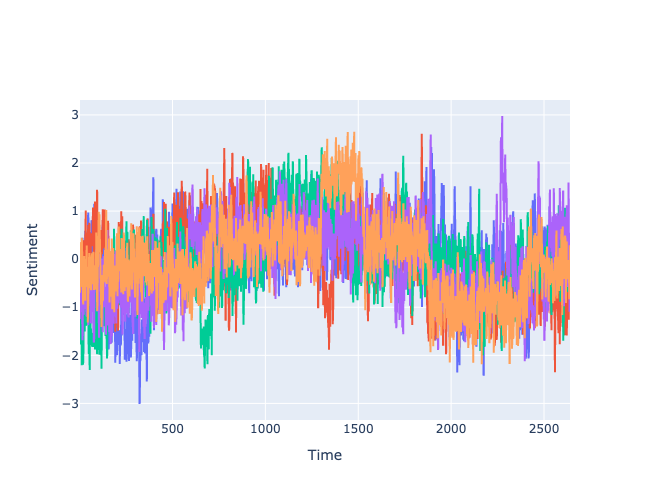

In [33]:
temp_df = rolling_df.loc[pca_df.sort_values(1).iloc[-5:].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

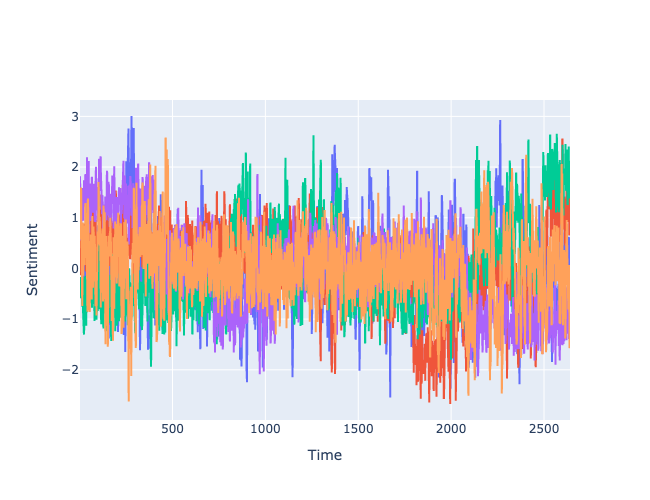

In [34]:
import plotly.graph_objects as go

temp_df = rolling_df.loc[pca_df.sort_values(1).iloc[midpoint-2:midpoint+3].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  )
fig.show()

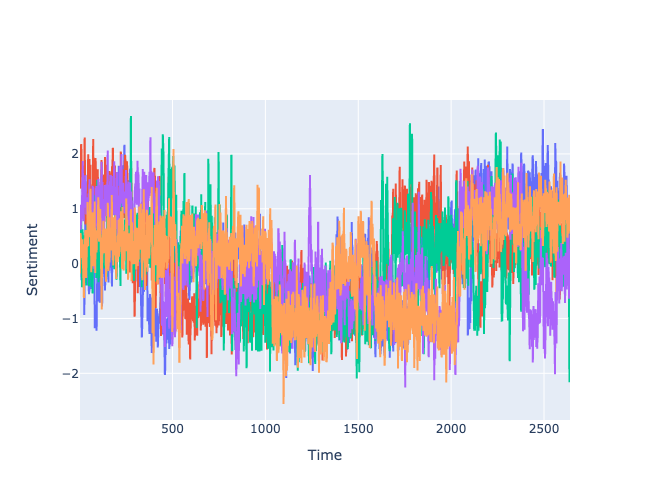

In [35]:
temp_df = rolling_df.loc[pca_df.sort_values(1).iloc[:5].index]
fig = go.Figure()
for index in temp_df.index:
    fig.add_trace(go.Scatter(x=temp_df.columns, y=temp_df.loc[index],
                    mode='lines'))
fig.update_layout(showlegend=False, 
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

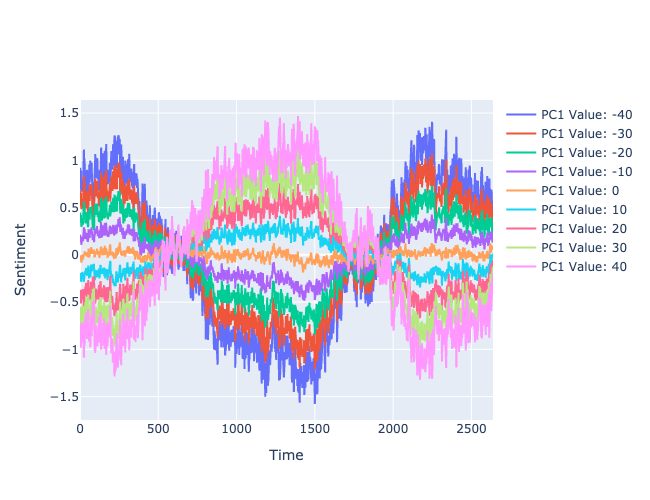

In [36]:
fig = go.Figure()

second_component_example = pd.DataFrame(columns=list(range(pca.n_components_)))

for i in range(-40, 41, 10):
    instance = pd.Series([0 for i in range(pca.n_components_)])
    instance[1] = i
    second_component_example.loc[i] = instance
    
second_component_example = pd.DataFrame(pca.inverse_transform(second_component_example), index=second_component_example.index)
    
for index in second_component_example.index:
    fig.add_trace(go.Scatter(x=second_component_example.columns, y=second_component_example.loc[index],
                    mode='lines', name="PC1 Value: {}".format(index)))
fig.update_layout(
                    width=650, 
                    height=500,
                    xaxis_title="Time",
                    yaxis_title="Sentiment",
                  ) 
fig.show()

# Clustering

To reduce noise, we will use a sliding, smoothing window of length 500.

As one distance metric, we use dynamic time warping, which should be invariant to small translations in the exact timing of patterns

In [37]:
if recalculate_all:
    from tslearn.metrics import cdist_dtw as dtw
    distances = dtw(sentiment_df, n_jobs=-1)

    dtw_df = pd.DataFrame(distances)
    dtw_df.index = sentiment_df.index
    dtw_df.columns = sentiment_df.index

    dtw_df.to_csv(os.path.join(intermediate_path, 'distances.csv'))
else:
    dtw_df = pd.read_csv(os.path.join(intermediate_path, 'distances.csv'), index_col=0)

# Clustering

## Setup

In [38]:
rolling_window = 500

In [39]:
rolling_sentiment_df = sentiment_df.rolling(rolling_window, axis=1, center=True).mean().dropna(axis=1)

In [40]:
def find_subplot_dimensions(n):
    return (int(np.ceil(n / 3)), 3)

In [41]:
sentiment_df

,0,1,2,3,4,5,6,7,8,9,...,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640
8mm_WELLES,0.908352,0.599392,0.981812,0.666667,1.407726,0.552735,0.552743,1.435063,1.040077,1.000000,...,-0.315074,0.362101,-0.088178,1.000000,0.684035,1.642905,1.000000,1.690735,0.707853,1.000000
8mm_MAX,0.133478,1.467728,0.682168,1.367040,0.085399,1.414379,0.437726,1.339250,1.006626,0.557143,...,0.122684,-0.069690,-0.586802,0.225706,-0.904976,-0.951858,0.343157,0.235379,-0.026645,-0.647823
8mm_EDDIE,1.152269,1.370937,0.716086,1.136984,1.820429,2.201102,1.293971,1.871592,0.559800,1.823927,...,2.509879,2.375387,2.848788,1.769454,1.368375,1.751700,2.102590,2.028594,1.806741,1.062189
ALongKissGoodnight_SAMANTHA,1.215862,1.904929,1.213003,1.279477,1.262643,1.182169,1.427457,1.181401,0.856541,0.634793,...,0.743537,0.007611,0.553037,0.486343,0.647546,0.553455,0.674210,0.357096,0.526890,-0.063339
ALongKissGoodnight_HENESSEY,0.859200,1.612144,1.140316,0.990792,1.834536,0.401059,0.511698,1.753812,1.020229,0.893232,...,1.855799,1.679442,2.338104,1.594867,2.374125,2.091482,1.980175,1.710964,1.403388,1.714950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wildwildwest_GORDON,1.418172,0.375468,0.702491,0.714924,0.496033,1.017795,2.011621,1.765621,0.986142,1.281831,...,0.501328,0.684037,1.225727,1.543569,2.167703,0.703957,2.352777,1.144415,-0.153104,1.500000
wildwildwest_LOVELESS,2.058928,0.936545,0.341132,2.023641,1.153947,0.306303,1.232572,1.166230,-0.436519,0.977547,...,2.012023,0.102133,0.723339,0.918293,-0.210263,1.335640,0.881435,1.999231,-0.041154,1.168035
willow_WILLOW,1.700049,1.119637,0.494020,2.475646,0.113685,0.522848,0.445874,-0.018947,0.861403,0.276855,...,1.632425,2.327231,1.000000,1.030291,0.591373,1.135382,1.668532,0.180351,0.787853,1.000000
willow_SORSHA,1.861065,2.225908,1.022405,2.199148,1.649670,0.763967,2.117649,1.018825,1.057691,1.691137,...,-0.328895,-0.161747,0.176475,0.284139,-1.056762,0.933138,-0.592168,0.720775,-0.009965,0.457817


In [42]:
# We settled on 9 clusters as a minimum of the optimal clusterings from all of our models
n_clusters=9

def cluster(data, model):
    """
    This function helps to calculate and visualize clusters using whatever
    clustering model is passed in
    """
    visualizer = KElbowVisualizer(model, k=(2,30), timings=False)
    visualizer.fit(data)        # Fit data to visualizer
    visualizer.show()
    # n_clusters = visualizer.elbow_value_
        
    model.set_params(n_clusters=n_clusters)
    cluster_df = pd.Series(model.fit_predict(data), index=sentiment_df.index)
    cluster_df = cluster_df.rename({0: 'cluster'})
    clusters = cluster_df.unique()
    clusters.sort()
    rows, cols = find_subplot_dimensions(n_clusters)
    outer_fig = make_subplots(
        rows=rows, 
        cols=cols, 
        shared_xaxes='all', 
        shared_yaxes='all',
        x_title='Time',
        y_title='Sentiment',
        horizontal_spacing=0.03,
        vertical_spacing=0.05,
        subplot_titles=(["Cluster {}".format(i) for i in range(n_clusters)])
    )
    outer_fig.update_layout(showlegend=False, 
                    width=(cols+1)*200, 
                    height=(rows+1)*200,
                )

    
    plotted_count = 0
    
    for i in range(1, rows+1):
        for j in range(1, cols+1):
            if plotted_count < n_clusters:
                indices = cluster_df[cluster_df == plotted_count].dropna().index
                temp_df = rolling_sentiment_df.loc[indices]
                
                # Normalize the data for clean visualizations
                temp_df = temp_df.copy().T
                temp_df = (temp_df - temp_df.mean()) / temp_df.std()
                temp_df = temp_df.T

                for index in temp_df.index:
                    outer_fig.append_trace(
                        go.Scatter(
                            x=temp_df.columns, y=temp_df.loc[index],
                            mode='lines',
                            # text=index, 
                            marker=dict(
                                color='rgba(135, 206, 250, 0.8)',
                            ),
                            hoverinfo='none',
                            ), 
                        i, 
                        j)
                outer_fig.append_trace(
                    go.Scatter(
                        x=temp_df.columns, y=temp_df.mean(),
                        mode='lines',
                        marker=dict(
                            color='rgba(128, 128, 128, .8)',
                        ),
                    ), 
                    i, 
                    j
                )
                plotted_count += 1
    outer_fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(
        title=dict(
            text='Sentiment'
        )
    )
    outer_fig.show()
    return cluster_df

In [43]:
if not os.path.exists(os.path.join(base_path, 'clusters.csv')):
    clusters_df = pd.DataFrame(index=sentiment_df.index)
else:
    clusters_df = pd.read_csv(os.path.join(base_path, 'clusters.csv'), index_col=0)

### Euclidean

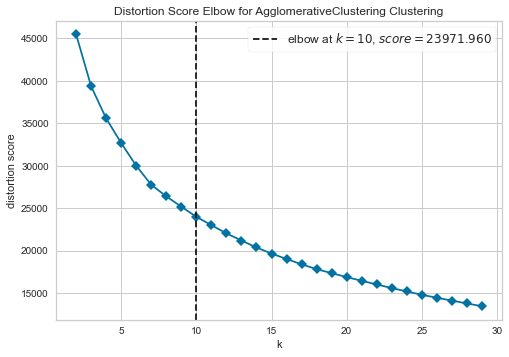

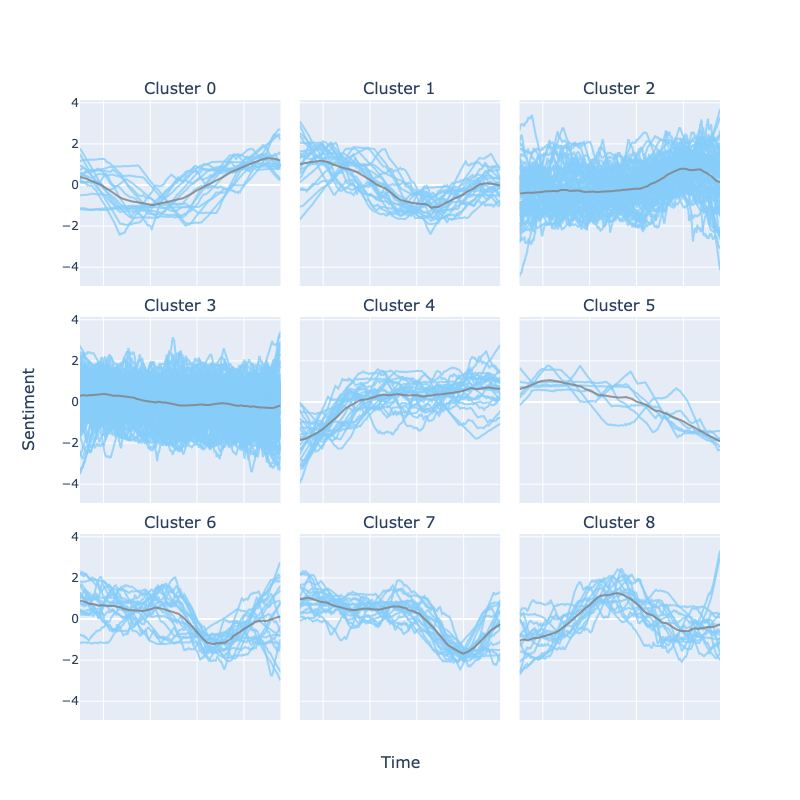

In [44]:
model = AgglomerativeClustering()
clusters_df['euclidean_sentiment'] = cluster(rolling_sentiment_df, model)

### Manhattan

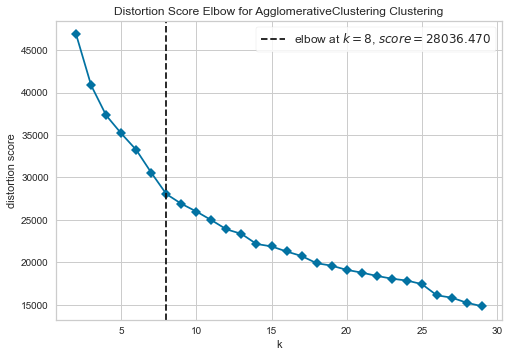

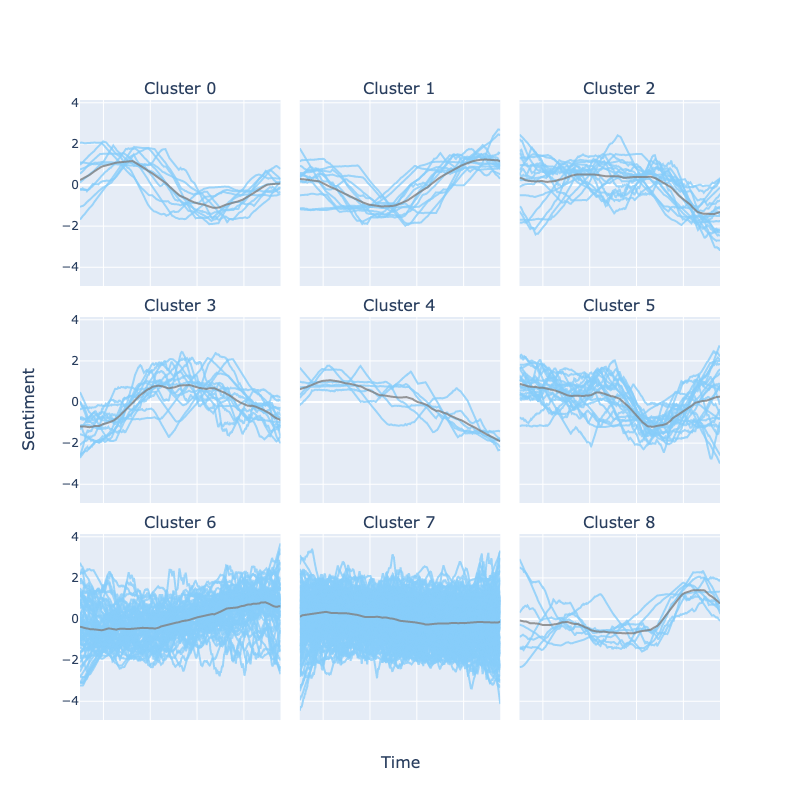

In [45]:
model = AgglomerativeClustering(linkage='complete', affinity='manhattan')
clusters_df['manhattan_sentiment'] = cluster(rolling_sentiment_df, model)

## On the differences between each timepoint

### Setup

In [46]:
diff_df = rolling_sentiment_df.diff(axis=1).dropna(axis=1)

### Euclidean

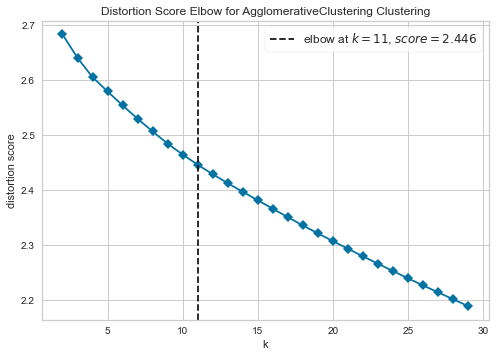

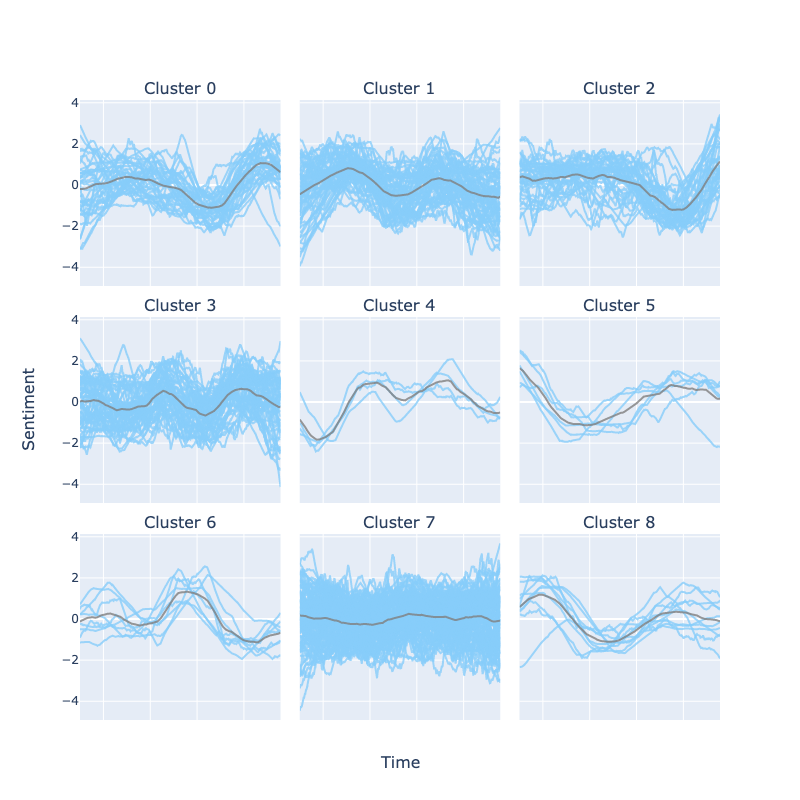

In [47]:
model = AgglomerativeClustering()
clusters_df['euclidean_diff'] = cluster(diff_df, model)

### Manhattan

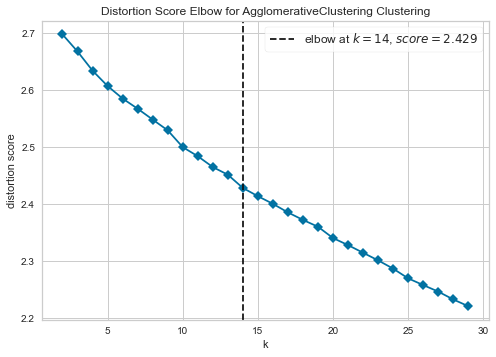

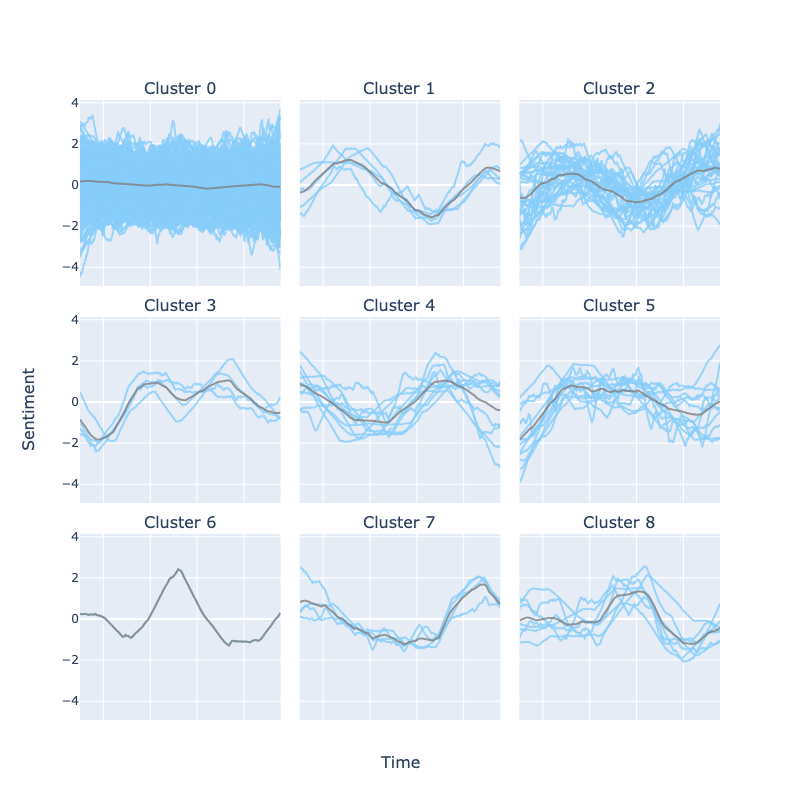

In [48]:
model = AgglomerativeClustering(linkage='complete', affinity='manhattan')
clusters_df['manhattan_diff'] = cluster(diff_df, model)

## On dynamic time warp distances

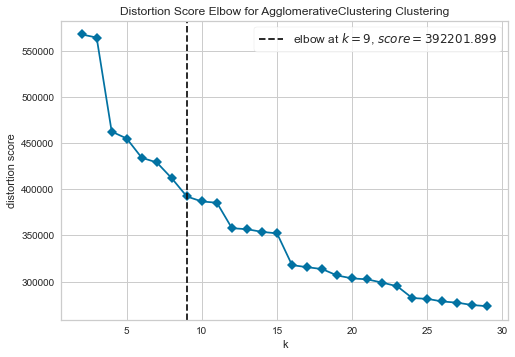

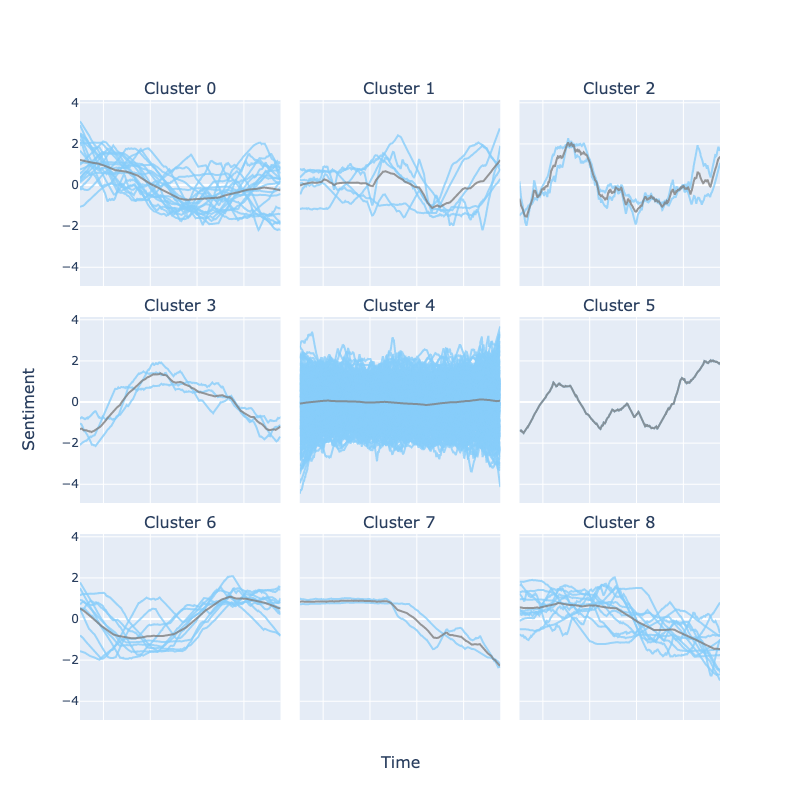

In [49]:
model = AgglomerativeClustering(affinity='precomputed', linkage='complete')
clusters_df['dtw_sentiment'] = cluster(dtw_df, model)

## Gold standard

We read in the gold standard clusterings and standardize their formatting

In [50]:
gold_standard_df = pd.read_json(os.path.join(base_path, 'tvtropes.clusters.json')).T.drop('id', axis=1)
gold_standard_df.sort_values('movie')
gold_standard_df.to_csv(os.path.join(base_path, 'gold_standard.csv'))

In [51]:
if not 'gold_standard_cluster' in clusters_df.columns:
    clusters_df['gold_standard_cluster'] = '0' 

In [52]:
for loc in clusters_df.index:
    if not pd.isna(clusters_df.loc[loc, 'gold_standard_cluster']) and clusters_df.loc[loc, 'gold_standard_cluster'] == '0':
        mapping = input(loc)
        clusters_df.loc[loc, 'gold_standard_cluster'] = mapping
        clusters_df.to_csv(os.path.join(base_path, 'clusters.csv'))
    else:
        pass

There are 77 characters who appear in both datasets (have both inferred and gold standard clusterings):

In [53]:
clusters_df[~clusters_df['gold_standard_cluster'].isna()]

,euclidean_sentiment,manhattan_sentiment,euclidean_diff,manhattan_diff,dtw_sentiment,gold_standard_cluster
ALongKissGoodnight_TIMOTHY,2,7,1,0,4,casanova
Aliens_RIPLEY,1,7,1,0,4,final_girl
Aliens_BURKE,2,7,3,0,4,corrupt_corporate_executive
AllThePresidentsMen_BRADLEE,4,2,1,5,4,the_editor
Arthur_ARTHUR,3,6,7,0,4,ditz
...,...,...,...,...,...,...
tron_FLYNN,4,2,4,3,4,playful_hacker
tronlegacy_FLYNN,3,7,3,2,4,playful_hacker
uturn_JAKE,5,4,7,0,0,crazy_jealous_guy
wildwildwest_GORDON,3,7,7,0,4,gadgeteer_genius


#### Cluster Purities

According to Bamman et al. 2013 cluster purity metric

In [54]:
purity_df = clusters_df.copy().dropna()
value_counts = purity_df.value_counts('gold_standard_cluster')
supported_clusters = value_counts.where(value_counts > 1).dropna().index.to_list()
purity_df[purity_df['gold_standard_cluster'].isin(supported_clusters)].value_counts('gold_standard_cluster')

clusterings = purity_df.columns.to_list()
clusterings.remove('gold_standard_cluster')

purities = {}

for clustering in clusterings:
    purity = pd.crosstab(purity_df[clustering], purity_df['gold_standard_cluster']).max().sum() / len(purity_df)
    purities[clustering] = purity

In [55]:
purities

{'euclidean_sentiment': 0.7402597402597403,
 'manhattan_sentiment': 0.7402597402597403,
 'euclidean_diff': 0.6883116883116883,
 'manhattan_diff': 0.8701298701298701,
 'dtw_sentiment': 0.9090909090909091}

#### Baseline cluster purities

Assigning each character randomly to a cluster based on the proportion of that cluster in the original clustering (According to Bamman et al. 2013 baseline methodology)

In [56]:
cluster_distributions_df = pd.DataFrame([clusters_df[clustering].value_counts().sort_index() / len(clusters_df) for clustering in clusterings])

In [57]:
np.random.seed(0)
purity_baseline_df = purity_df.copy()
for clustering in clusterings:
    purity_baseline_df[clustering] = np.random.choice(n_clusters, size=len(purity_baseline_df), p=cluster_distributions_df.loc[clustering])
    
baseline_purities = {}

for clustering in clusterings:
    purity = pd.crosstab(purity_baseline_df[clustering], purity_baseline_df['gold_standard_cluster']).max().sum() / len(purity_baseline_df)
    baseline_purities[clustering] = purity

In [58]:
baseline_purities

{'euclidean_sentiment': 0.6883116883116883,
 'manhattan_sentiment': 0.7532467532467533,
 'euclidean_diff': 0.6233766233766234,
 'manhattan_diff': 0.8831168831168831,
 'dtw_sentiment': 0.8961038961038961}

In [59]:
scores = {}
for key in baseline_purities:
    scores[key] = purities[key] - baseline_purities[key]
scores

{'euclidean_sentiment': 0.051948051948051965,
 'manhattan_sentiment': -0.012987012987012991,
 'euclidean_diff': 0.06493506493506496,
 'manhattan_diff': -0.012987012987012991,
 'dtw_sentiment': 0.012987012987012991}

In [60]:
average_score = np.mean(list(scores.values()))
average_score

0.020779220779220786

#### Visual inspection of gold-standard clusters

In [61]:
purity_df[purity_df['gold_standard_cluster'].isin(supported_clusters)].value_counts('gold_standard_cluster')

gold_standard_cluster
stoner                         5
crazy_jealous_guy              5
stupid_crooks                  4
loveable_rogue                 4
corrupt_corporate_executive    3
master_swordsman               3
adventurer_archaeologist       2
gadgeteer_genius               2
the_editor                     2
playful_hacker                 2
loser_protagonist              2
granola_person                 2
final_girl                     2
bounty_hunter                  2
father_to_his_men              2
evil_prince                    2
dumb_muscle                    2
drill_sargeant_nasty           2
consummate_professional        2
chanteuse                      2
byronic_hero                   2
warrior_poet                   2
dtype: int64

['haroldandkumar_HAROLD', 'haroldandkumar_KUMAR', 'pineappleexpress_DALE', 'pineappleexpress_SAUL', 'pineappleexpress_RED']


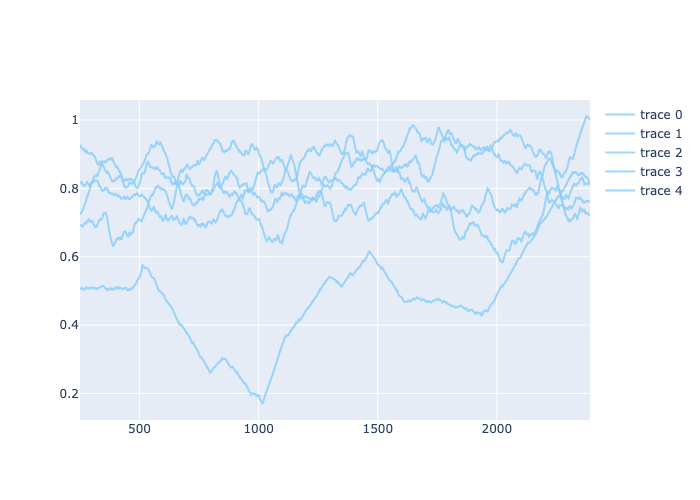

In [62]:
stoners = purity_df[purity_df['gold_standard_cluster'] == 'stoner'].index.to_list()
print(stoners)
fig = go.Figure()
for stoner in stoners:
    temp_df = rolling_sentiment_df.loc[stoner]
    fig.add_trace(go.Scatter(
            x=temp_df.index, y=temp_df.values,
            mode='lines',
            # text=index, 
            marker=dict(
                color='rgba(135, 206, 250, 0.8)',
            ),
            hoverinfo='none',
            ))
fig.show()

['LAConfidential_BUD', 'piano_STEWART', 'rockyhorrorpictureshow_FRANK', 'scarface_TONY', 'uturn_JAKE']


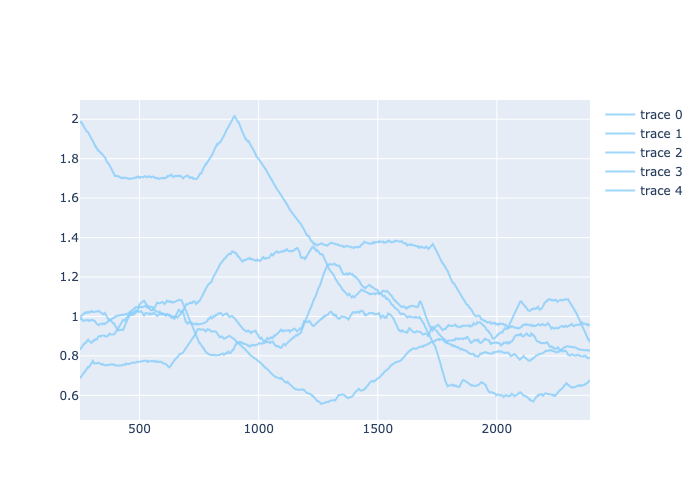

In [63]:
stoners = purity_df[purity_df['gold_standard_cluster'] == 'crazy_jealous_guy'].index.to_list()
print(stoners)
fig = go.Figure()
for stoner in stoners:
    temp_df = rolling_sentiment_df.loc[stoner]
    fig.add_trace(go.Scatter(
            x=temp_df.index, y=temp_df.values,
            mode='lines',
            # text=index, 
            marker=dict(
                color='rgba(135, 206, 250, 0.8)',
            ),
            hoverinfo='none',
            ))
fig.show()

['Snatch_VINNY', 'Snatch_SOL', 'fargo_JERRY', 'pulpfiction_VINCENT']


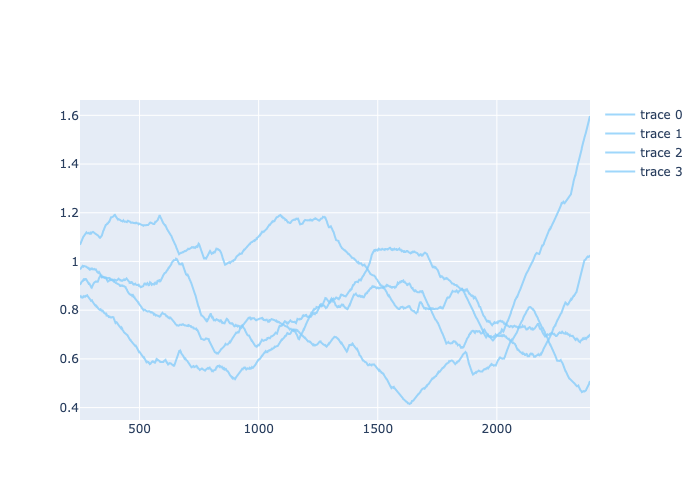

In [64]:
stoners = purity_df[purity_df['gold_standard_cluster'] == 'stupid_crooks'].index.to_list()
print(stoners)
fig = go.Figure()
for stoner in stoners:
    temp_df = rolling_sentiment_df.loc[stoner]
    fig.add_trace(go.Scatter(
            x=temp_df.index, y=temp_df.values,
            mode='lines',
            # text=index, 
            marker=dict(
                color='rgba(135, 206, 250, 0.8)',
            ),
            hoverinfo='none',
            ))
fig.show()

['Inception_EAMES', "Pirates-of-the-Caribbean-Dead-Man's-Chest_JACKSPARROW", 'StarWarsANewHope_HAN', 'StarWarsTheEmpireStrikesBack_HAN']


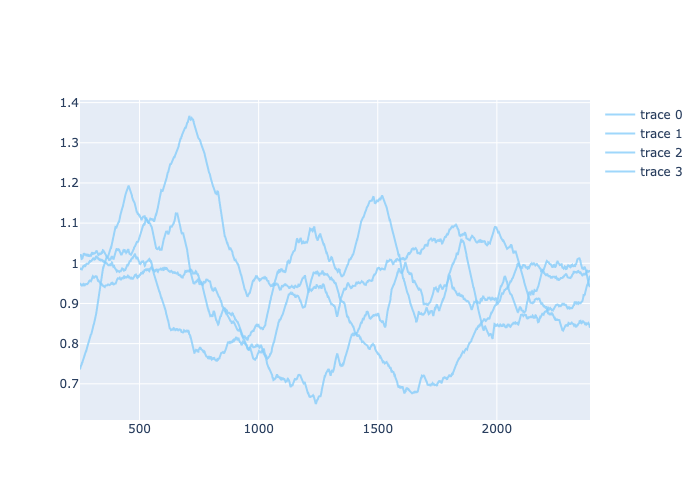

In [65]:
stoners = purity_df[purity_df['gold_standard_cluster'] == 'loveable_rogue'].index.to_list()
print(stoners)
fig = go.Figure()
for stoner in stoners:
    temp_df = rolling_sentiment_df.loc[stoner]
    fig.add_trace(go.Scatter(
            x=temp_df.index, y=temp_df.values,
            mode='lines',
            # text=index, 
            marker=dict(
                color='rgba(135, 206, 250, 0.8)',
            ),
            hoverinfo='none',
            ))
fig.show()